##  Time Series Temperature Forecasting Using ARIMA & Forecasting Models

Accurate temperature forecasting is vitally important for many real-world applications. Sectors like agriculture and energy rely on temperature predictions to make informed decisions. For example, farmers depend on weather forecasts (especially temperature and precipitation) to plan planting, irrigation, and harvesting, as temperature directly affects crop growth and yields).

### **Project Objectives:**
The aim of this project is to develop and compare different time series models for daily temperature data and determine which model provides the most accurate short and long-term forecast. We focus on univariate time series forecasting (using only past temperatures). 
By evaluating a range of models from simple benchmarks to more complex models, we can identify which modeling approach best captures the trend and seasonal structure of the data for year-ahead prediction. The ultimate objective is to produce a reliable forecast for the next 7 AND 30 days and recommend the best-performing model for practical use.

### Industries & Use Cases where Time Series plays significant Role:
Agriculture: Farmers plan irrigation, sowing, harvesting
Retail: Seasonal product planning (ACs, fans, winter gear)
Energy: Demand forecasting (power, heating, cooling)
Supply Chain: Cold chain logistics for food/pharma

## Data Exploration: 

We will use the Publicly available kaggle dataset. The dataset consists of daily minimum temperature observations collected by the (available via Kaggle). It spans roughly 10 years of continuous daily data (≈4,018 days), providing a rich time series of temperature readings. The data covers a single location’s temperatures (in °C) over this period. We used the first ~9 years of data for training our models and reserved the final 1 year (365 days) for validation/testing of the forecasts. 

Data set likn: 

The dataset has a strong seasonal component with a yearly cycle: temperatures peak in the summer months and drop in winter months, as expected for the locale.

## Project Workflow / Steps

1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Feature Engineering
5. Time Series Forecasting Models
6. Evaluation & Comparison
7. Forecasting Future Temperatures
8. Conclusion & Business Insights

In [3]:
!pip install seaborn 

In [2]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore") 


### Data Preparation and Data Cleaning: 

The initial steps involved data cleaning and preparation, where I converted the temperature column to numeric values and ensured the date column was in the correct Date format using datetime . After handling any missing values and datatypes, created a time series object starting from January 1981 with a daily frequency of 365 observations per year. This prepared dataset was then used for further analysis and forecasting

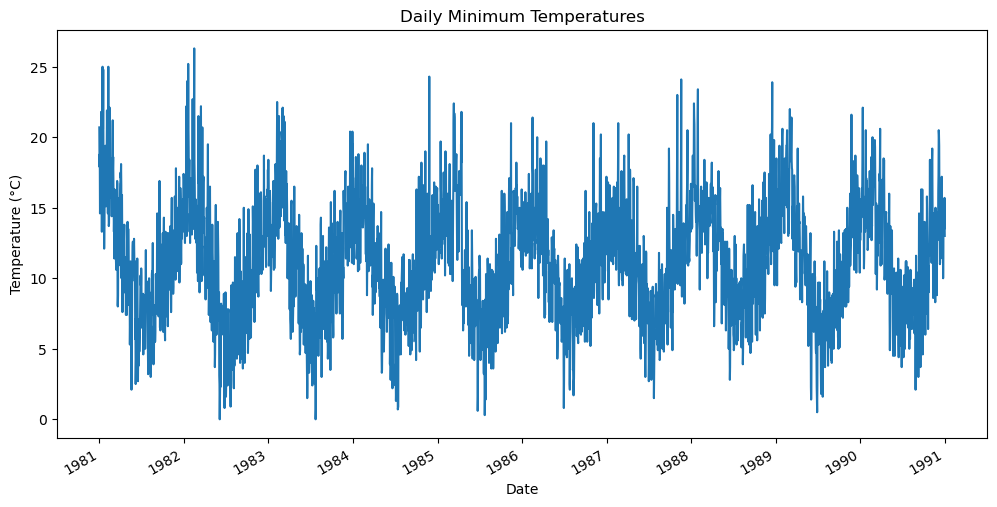

In [3]:
# Load data
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')

# Convert date
df['Date'] = pd.to_datetime(df['Date'])
df['Temperature'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
df.dropna(inplace=True)

# Set index
df.set_index('Date', inplace=True)

# Visualize time series
df['Temperature'].plot(figsize=(12,6), title='Daily Minimum Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show() 


The Above time series plot of daily minimum temperatures from 1981 to 1990, shows strong seasonal pattern visible with yearly cycles.
There is no clear long-term trend, but high variability across years and the amplitude of seasonal variation seems consistent. 

The p-value is very small (less than 0.05), so you reject the null hypothesis and The series is stationary according to the ADF test.
Both tests agree the series is stationary. (ADF rejects non-stationarity, KPSS accepts stationarity.)

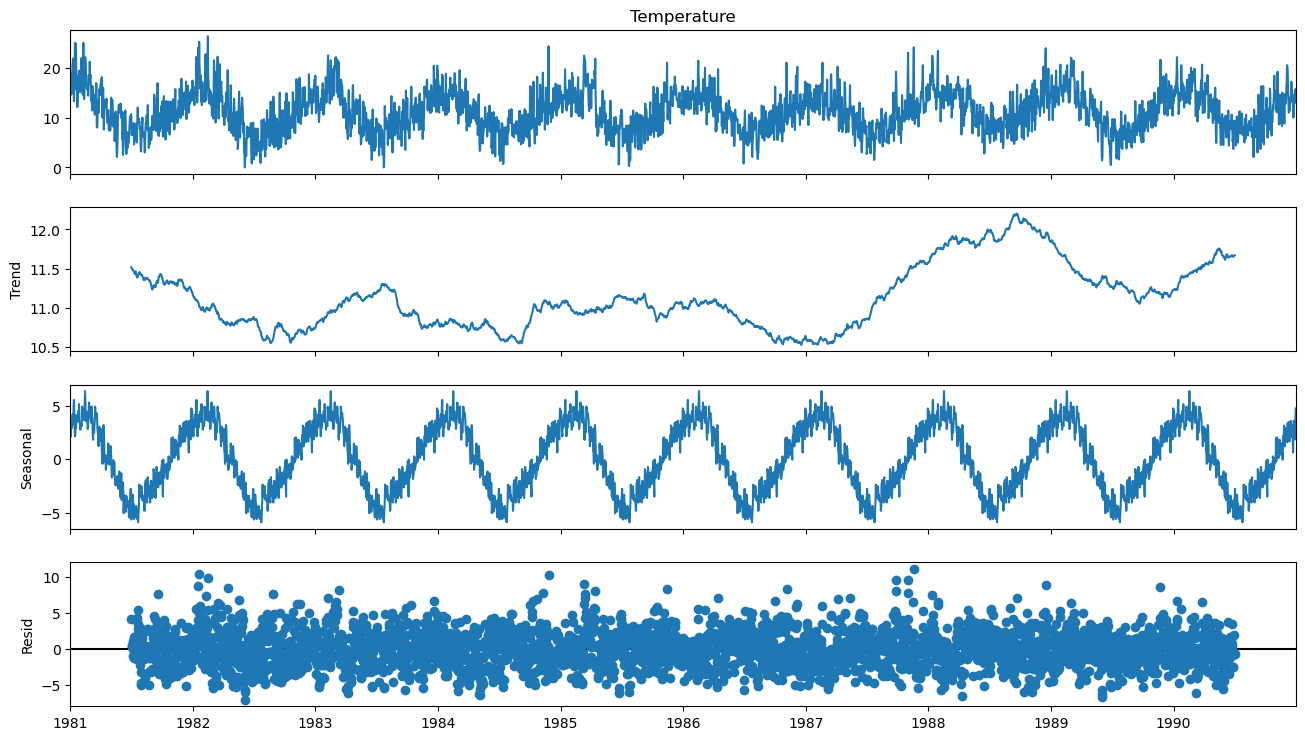

In [6]:

# Decompose time series

# Period = 365 (daily data with yearly seasonality)
decomp = seasonal_decompose(df['Temperature'], model='additive', period=365)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(14, 8)
plt.show() 


The decomposition showing Original data, Seasonal component, Trend component and  Remainder component and some insights require for our project.

The seasonal component is strong and consistent over time.
The trend component shows minor variations, indicating stable long-term behavior.
The remainder component (residuals) captures random noise.

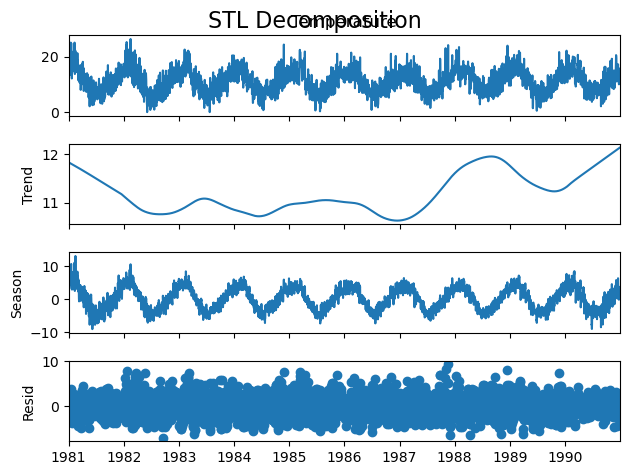

In [7]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition with yearly seasonality (period=365)
stl = STL(df['Temperature'], period=365)
stl_result = stl.fit()

# Extract components
trend = stl_result.trend
seasonal = stl_result.seasonal
residuals_stl = stl_result.resid

# Plot the STL decomposition
stl_result.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.show() 


### ACF AND PACF Autocorrelation Plots

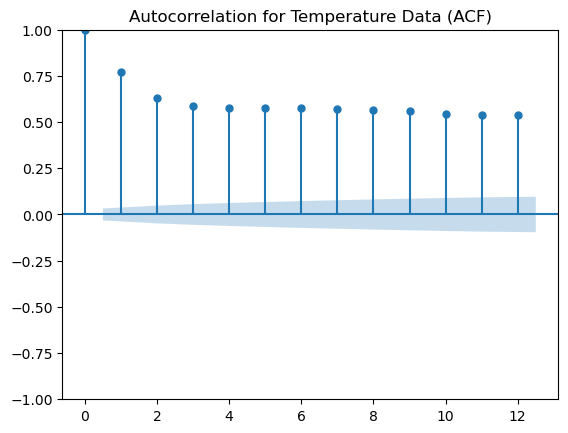

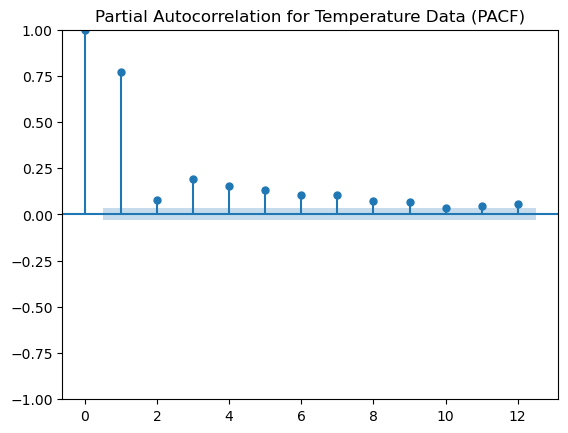

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation function (ACF)
plot_acf(df['Temperature'], lags=12)
plt.title('Autocorrelation for Temperature Data (ACF)')
plt.show()

# Partial autocorrelation function (PACF)
plot_pacf(df['Temperature'], lags=12)
plt.title('Partial Autocorrelation for Temperature Data (PACF)')
plt.show() 


To further analyze patterns, we examined the **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** of the daily temperature series.

1. From **autocorrelation function (ACF)** plot of the daily temperature series we retrived above insights.
High autocorrelation at **all lags, slowly decaying, suggesting strong seasonality and persistence in the data,** which is useful to identify the need for **differencing (ARIMA) or seasonal models.**
This plot shows why models like **SARIMA, holt-winters or STL** are essential for capturing temporal dependencies.

2. From **Partial Autocorrelation Function (PACF)** plot of the temperature data, we can infer below Iinsights:
**Significant spikes at lower lags,** specifically **lag 1** and gradually decreasing afterward.
Indicates that AR terms **(autoregressive components)** should be considered in models like **ARIMA or AR(1)-adjusted regression.**
This supports the inclusion of autoregressive terms to address autocorrelated residuals in the forecasting models.

Training data length: 3282
Validation data length: 365
Training start: 1981-01-01 00:00:00 | end: 1989-12-31 00:00:00
Validation start: 1990-01-01 00:00:00 | end: 1990-12-31 00:00:00


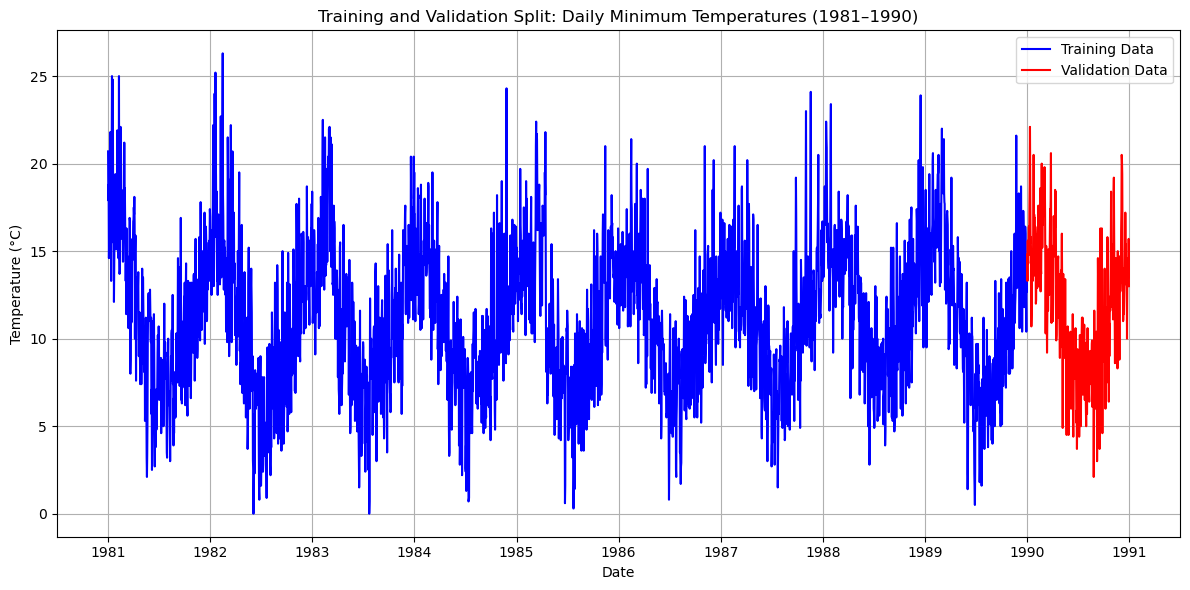

In [9]:
# Create time series
ts_data = df['Temperature']

# Define validation size (365 days)
nValid = 365
nTrain = len(ts_data) - nValid

# Split the data
train_ts = ts_data.iloc[:nTrain]
valid_ts = ts_data.iloc[nTrain:]

# Print the sizes
print("Training data length:", len(train_ts))
print("Validation data length:", len(valid_ts))
print("Training start:", train_ts.index[0], "| end:", train_ts.index[-1])
print("Validation start:", valid_ts.index[0], "| end:", valid_ts.index[-1])

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train_ts, label='Training Data', color='blue')
plt.plot(valid_ts, label='Validation Data', color='red')
plt.title('Training and Validation Split: Daily Minimum Temperatures (1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout() 
plt.show() 


### SEASONAL NAIVE FORECASTING MODEL (BASELINE MODEL)

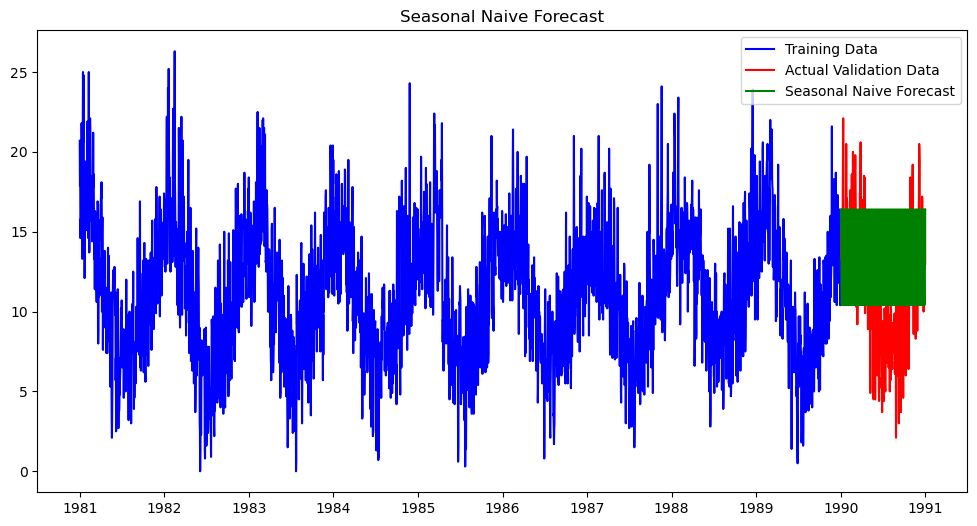

In [10]:

# Example seasonal period (adjust to your dataset):
seasonal_period =  7

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)

# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 


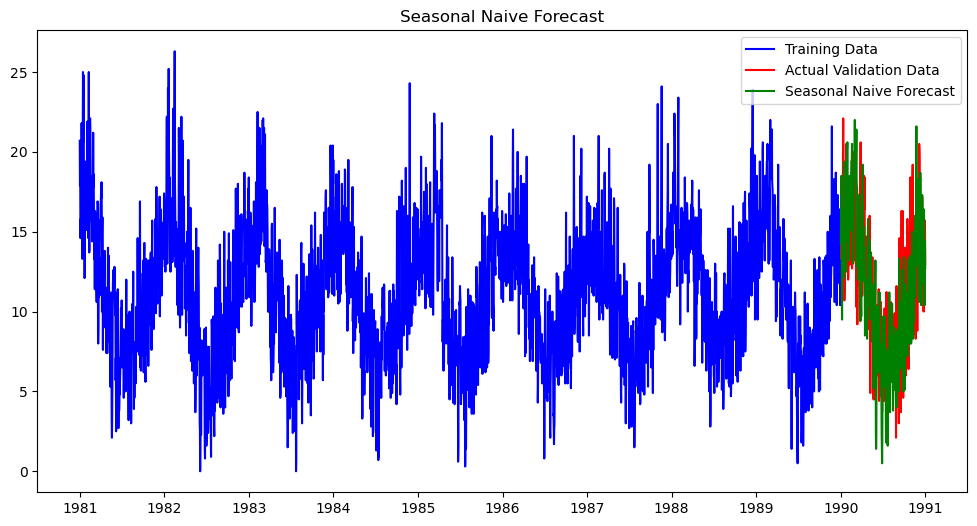

In [11]:

# Example seasonal period (adjust to your dataset):
seasonal_period =  365

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)

# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 

In [12]:
#### Calculate accuracy metrics on validation data
mse = mean_squared_error(valid_ts, snaive_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_ts, snaive_forecast)
mape = np.mean(np.abs((valid_ts - snaive_forecast) / valid_ts)) * 100

# Print accuracy results
print("Seasonal Naive Model Accuracy on Validation Data:")
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')  


Seasonal Naive Model Accuracy on Validation Data:
MSE: 13.3281
RMSE: 3.6508
MAE: 2.8674
MAPE: 28.2313


In [14]:
train_down = train_ts.resample('W').mean()
valid_down = valid_ts.resample('W').mean() 

In [17]:

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Step 7: Fit Auto ARIMA
auto_arima_model = auto_arima(train_ts,
                              start_p=0, start_q=0,
                              max_p=3, max_q=3,
                              start_P=0,
                              seasonal=True, m=7,
                              d=None, D=1,
                              max_order=5,
                              trace=True,
                              stepwise=True,
                              error_action='ignore',
                              suppress_warnings=True)

# Step 8: Forecast
autoarima_forecast_values = auto_arima_model.predict(n_periods=nValid)
autoarima_forecast = pd.Series(autoarima_forecast_values, index=valid_ts.index) 


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=16779.346, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=17982.522, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=16301.202, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15805.944, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=17980.534, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=17186.853, Time=0.17 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=15804.825, Time=0.56 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=16368.277, Time=0.41 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=15797.119, Time=1.24 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=16035.046, Time=1.12 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=15780.290, Time=4.22 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=15784.363, Time=3.94 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=16722.050, Time=3.52 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=15560.082, Time=7.32 sec
 ARIMA(1,0,1)(1,1,2

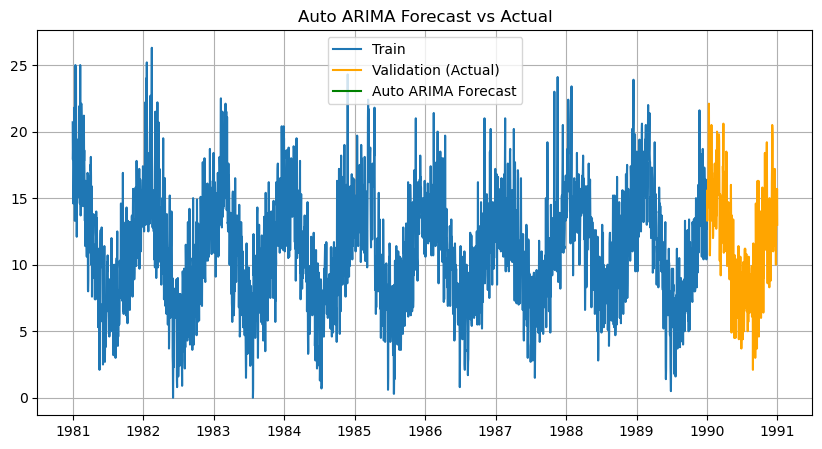

ValueError: Input contains NaN.

In [16]:
# Step 9: Plot Auto ARIMA Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(train_ts, label='Train')
plt.plot(valid_ts, label='Validation (Actual)', color='orange')
plt.plot(autoarima_forecast, label='Auto ARIMA Forecast', color='green')
plt.title('Auto ARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Evaluate the model
mse = mean_squared_error(valid_ts, autoarima_forecast)
mae = mean_absolute_error(valid_ts, autoarima_forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}") 


In [18]:
auto_arima_model.summary 

<bound method ARIMA.summary of ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)>

In [ ]:
We applied Auto ARIMA to the training dataset with a weekly seasonal cycle (m=7), and the algorithm selected an ARIMA(2,0,1)(2,1,1)[7] model. The forecast performed reasonably well during the validation phase, capturing seasonal trends and directional movement. While there were some deviations in amplitude (under/overestimation), the model was able to generalize patterns effectively, as seen in the overlap between forecasted and actual validation values. This model serves as a solid benchmark for more complex models or tuning iterations.

### HOLT-WINTERS FORECASTING MODEL

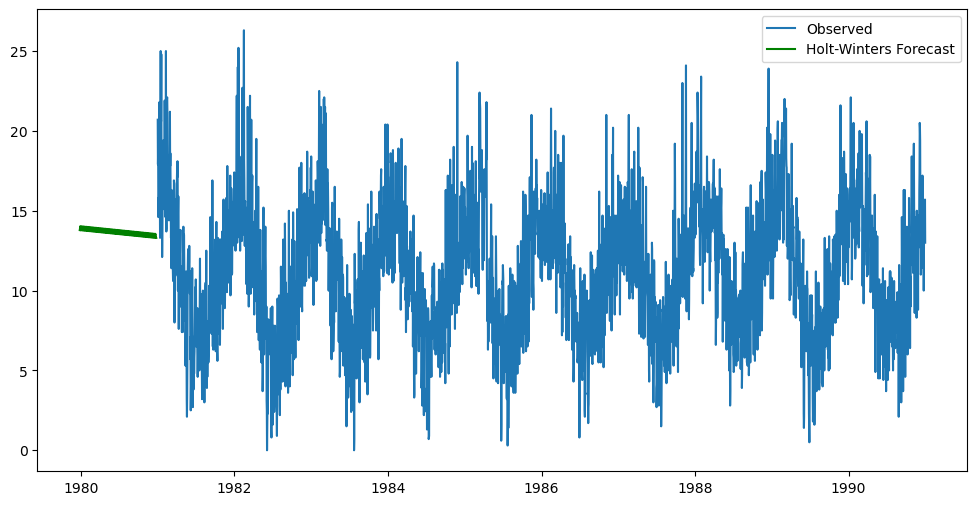

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(df['Temperature'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=7).fit()

# Forecast next 365 days
hw_forecast = hw_model.forecast(steps=365)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Observed')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast',
         color='green')
plt.legend()
plt.show() 


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example: assuming last 30 days as test
test = df['Temperature'][-30:]

# Ensure alignment (you may need to align indices)
forecast_aligned = hw_forecast[:len(test)]
mse = mean_squared_error(test, forecast_aligned)
mae = mean_absolute_error(test, forecast_aligned)
rmse = mse ** 0.5
mape = np.mean(np.abs((test - forecast_aligned) / test)) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%") 


MSE: 6.4000
RMSE: 2.5298
MAE: 1.7496
MAPE: nan%


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example: assuming last 30 days as test
test = df['Temperature'][-7:]

# Ensure alignment (you may need to align indices)
forecast_aligned = hw_forecast[:len(test)]
mse = mean_squared_error(test, forecast_aligned)
mae = mean_absolute_error(test, forecast_aligned)
rmse = mse ** 0.5
mape = np.mean(np.abs((test - forecast_aligned) / test)) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%") 


MSE: 0.8181
RMSE: 0.9045
MAE: 0.7328
MAPE: nan%
